In [3]:
import pandas as pd
import string
import datetime
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
from sklearn.metrics import f1_score
import gensim.corpora as corpora
import re
from pprint import pprint
import gensim
from gensim.utils import simple_preprocess
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from matplotlib import pyplot as plt
import matplotlib.colors as mcolors
from wordcloud import WordCloud

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/varunramakrishnan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [5]:
# Load data
train_feats = pd.read_csv('data/train.csv', delimiter=',', encoding="utf-8")
dev_feats = pd.read_csv('data/dev.csv', delimiter=',', encoding="utf-8")
test_feats = pd.read_csv('data/test.csv', delimiter=',', encoding="utf-8")

# Clear whitespace
train_feats.columns = train_feats.columns.str.strip()

In [6]:
# Dropping stuff!

# Drop all rows where time is NA?
print("Old length: ", len(train_feats))
train_feats = train_feats[train_feats['time'].notna()]
print("New length: ", len(train_feats))

# Just drop hashtags for now, too difficult for M3 to deal with
train_feats = train_feats.drop(['hashtags'], axis=1)

Old length:  195415
New length:  195415


In [7]:
# Feature manipulation to make them ready for the model
# Change sentiment labels to numbers!
train_feats['sentiment'] = train_feats['sentiment'].astype('category')
train_feats["sentiment"] = train_feats["sentiment"].cat.codes

# Change location
train_feats["user_location"] = train_feats["user_location"].astype('category')
train_feats["user_location"] = train_feats["user_location"].cat.codes

# Change place
train_feats["place"] = train_feats["place"].astype('category')
train_feats["place"] = train_feats["place"].cat.codes

# Change weekday
#train_feats["weekday"] = train_feats["weekday"].astype('category')
#train_feats["weekday"] = train_feats["weekday"].cat.codes

# Change month
train_feats["month"] = train_feats["month"].astype('category')
train_feats["month"] = train_feats["month"].cat.codes

# Change time to datetime object
#train_feats['time'] = train_feats['time'].apply(lambda x: datetime.datetime.strptime(str(x), '%H:%M:%S'))

# Add hour and minute columns
#train_feats['hour'] = train_feats['time'].apply(lambda x: x.hour)
#train_feats['minute'] = train_feats['time'].apply(lambda x: x.minute)

# Drop time
train_feats = train_feats.drop(['time'], axis=1)

# Change all the bool types to numeric
train_feats["num_present"] = train_feats["num_present"].astype(int)
train_feats["trump_present"] = train_feats["trump_present"].astype(int)
#train_feats["hashtag_present"] = train_feats["hashtag_present"].astype(int)
train_feats["covid"] = train_feats["covid"].astype(int)
train_feats["vaccine"] = train_feats["vaccine"].astype(int)
train_feats["profanity_present"] = train_feats["profanity_present"].astype(int)
#train_feats["emoji_present"] = train_feats["emoji_present"].astype(int)
train_feats["url_present"] = train_feats["url_present"].astype(int)
#train_feats["question_exclamation_present"] = train_feats["question_exclamation_present"].astype(int)

In [8]:
# Remove punctuation
train_feats['text'] = \
train_feats['text'].map(lambda x: re.sub('[,\.!?]', '', x))
# Convert the titles to lowercase
train_feats['text'] = \
train_feats['text'].map(lambda x: x.lower())
# Print out the first rows of papers
train_feats['text'].head()

0    @letdwn666 @prisonweddingg bro thx for sharing...
1    “is there a corona virus no it may possibly be...
2    @drharshvardhan sir\ncorona symptoms looking 7...
3    snakes who speaks from both side of there mout...
4    the inventor of the corona virus vaccine shoul...
Name: text, dtype: object

In [9]:
# More processing of data
stop_words = stopwords.words('english')
# Add these common stop words from Tweets
stop_words.extend(['from', 'subject', 're', 'edu', 'use', 'https', 'tco', 'rt', 'don\'', 'rsgt', 't', 'vaccine',
'vaccines', 'amp', 'covid'])

# Two helper functions that helps with transforming the words
def sentence_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))

def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) 
             if word not in stop_words] for doc in texts]

# Extract text data into a list
data = train_feats.text.values.tolist()
data_words = list(sentence_to_words(data))

# Remove stop words finally
data_words = remove_stopwords(data_words)

In [10]:
# Create Dictionary
id2word = corpora.Dictionary(data_words)
# Create Corpus
texts = data_words
# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

In [11]:
# number of topics
num_topics = 6
# Build LDA model
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=num_topics)
# Print the Keyword in the 6 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.008*"people" + 0.007*"doses" + 0.007*"get" + 0.007*"th" + 0.007*"take" + '
  '0.007*"pfizer" + 0.006*"least" + 0.006*"one" + 0.005*"someone" + '
  '0.005*"health"'),
 (1,
  '0.012*"get" + 0.010*"us" + 0.008*"first" + 0.007*"coronavirus" + '
  '0.006*"take" + 0.006*"pfizer" + 0.006*"people" + 0.006*"trump" + '
  '0.005*"one" + 0.005*"dose"'),
 (2,
  '0.019*"would" + 0.015*"made" + 0.013*"pfizer" + 0.011*"states" + '
  '0.009*"moderna" + 0.009*"trump" + 0.007*"says" + 0.007*"week" + '
  '0.006*"next" + 0.006*"js"'),
 (3,
  '0.038*"get" + 0.025*"got" + 0.024*"everyone" + 0.017*"bihar" + '
  '0.012*"never" + 0.012*"free" + 0.011*"said" + 0.010*"pm" + 0.009*"getting" '
  '+ 0.009*"elections"'),
 (4,
  '0.012*"one" + 0.012*"people" + 0.011*"get" + 0.011*"pfizer" + 0.009*"need" '
  '+ 0.008*"know" + 0.007*"social" + 0.005*"number" + 0.005*"like" + '
  '0.004*"virus"'),
 (5,
  '0.019*"get" + 0.012*"need" + 0.012*"system" + 0.011*"asks" + 0.011*"online" '
  '+ 0.011*"sign" + 0.009*"se

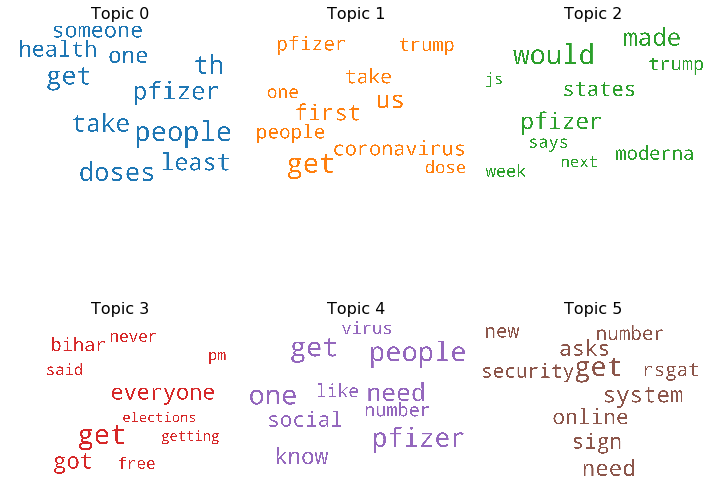

In [12]:
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = lda_model.show_topics(formatted=False)

fig, axes = plt.subplots(2, 3, figsize=(10,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()